# Model Interpretation for Pretrained VGG-16 Model: Neural activation classification with Autoencoder

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

Captum library privides function of Layer Conductance, that helps to evaluate importance of each neuron within a given Layer

In [ ]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [ ]:
model = models.vgg16(pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 300MB/s]


Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-12-25 07:53:34--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.225.200, 52.216.115.45, 54.231.164.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.225.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.09s   

2023-12-25 07:53:34 (403 KB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [ ]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [ ]:
### Rename files

import os
import glob

# Replace these values with your desired folder and renaming criteria
folder_path = '/content'
file_extension = '.jpg'  # Change to the desired file extension
name_pattern = 'animal_{}'  # Change to your preferred name pattern

# Get a list of files that match the criteria
files_to_rename = glob.glob(os.path.join(folder_path, f"*{file_extension}"))

# Iterate through the files and rename them
for index, old_file_path in enumerate(files_to_rename):
    # Extract the file's base name without extension
    base_name = os.path.splitext(os.path.basename(old_file_path))[0]

    # Construct the new name using the pattern
    new_name = name_pattern.format(index + 1)

    # Create the new file path with the same extension as the old file
    new_file_path = os.path.join(folder_path, f"{new_name}{file_extension}")

    # Rename the file
    os.rename(old_file_path, new_file_path)

print("Files renamed successfully.")

Files renamed successfully.


Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/animal_1.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [ ]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: fox_squirrel ( 0.38104650378227234 )


In [ ]:
pred_label_idx.item()

281

In [ ]:
layer_conv=model.features[14] # Corresponds to the 7th layer

## 3- Layer Conductance

In [ ]:
from captum.attr import LayerConductance
cond =LayerConductance(model, layer_conv)

In [ ]:
cond =LayerConductance(model,layer_conv)
cond_vals = cond.attribute(input,target=291)
cond_vals = cond_vals.detach().numpy()
p=cond_vals.shape[1]
q=cond_vals.shape[2]*cond_vals.shape[3]
cond_vals_flatten_conv=cond_vals.reshape((p,q))

In [ ]:
cond_vals_flatten_conv.shape

(256, 3136)

In [ ]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.4f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        cmap = plt.get_cmap('copper')
        norm = plt.Normalize(importances.min(), importances.max())
        colors = cmap(norm(importances))
        plt.bar(x_pos, importances, align='center',color=colors)
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


In [ ]:
visualize_importances(range(256),np.mean(cond_vals_flatten_conv, axis=1),title="Average Neuron Importances", axis_title="Neurons")

In [ ]:
importance=np.mean(cond_vals_flatten_conv, axis=1)
np.where(importance==np.max(importance))

(array([110]),)

In [ ]:
vector=[]

for i in range(256):
  vector.append(np.mean(cond_vals_flatten_conv[i,]))

In [ ]:
################################################################################

In [ ]:
merged_array=vector
y=[prediction_score.squeeze().item()]
label=['lion']
for i in range(2,536):
  transform = transforms.Compose([ transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
  transform_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  img = Image.open('/content/animal_'+str(i)+'.jpg')
  transformed_img = transform(img)
  input = transform_normalize(transformed_img)
  input = input.unsqueeze(0)
  output = model(input)
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, 1)
  pred_label_idx.squeeze_()
  predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
  y.append(prediction_score.squeeze().item())
  label.append(predicted_label)
  index=pred_label_idx.item()
  cond =LayerConductance(model,layer_conv)
  cond_vals = cond.attribute(input,target=291)
  cond_vals = cond_vals.detach().numpy()
  p=cond_vals.shape[1]
  q=cond_vals.shape[2]*cond_vals.shape[3]
  cond_vals_flatten=cond_vals.reshape((p,q))
  var=[]
  for j in range(256):
    var.append(np.mean(cond_vals_flatten[j,]))


  merged_array = np.column_stack((merged_array,var))

In [ ]:
merged_array.shape

(256, 535)

In [ ]:
len(label)

535

In [ ]:
############################################################################

In [ ]:
All_data=merged_array

In [ ]:
#########################################

In [ ]:
All_data=np.concatenate((All_data,merged_array))

In [ ]:
All_data.shape

(4480, 299)

In [ ]:
X=pd.DataFrame(np.transpose(All_data))

## 4- Data processing

In [ ]:
import pandas as pd

In [ ]:
X=pd.DataFrame(np.transpose(merged_array))

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.000005,3.151410e-08,-0.000026,0.000022,-0.000010,3.126666e-05,0.000039,-0.000018,-0.000073,0.000179,...,-0.000054,-0.000039,7.484285e-07,-0.000017,-0.000047,0.000062,-0.000007,-0.000084,-0.000020,-0.000085
1,0.000005,-6.914782e-06,0.000074,-0.000030,0.000035,-1.843757e-07,0.000061,0.000010,0.000064,0.000165,...,-0.000093,0.000046,1.124068e-05,0.000003,-0.000132,-0.000028,-0.000046,-0.000087,-0.000007,-0.000025
2,0.000012,-3.425074e-05,0.000050,0.000121,0.000045,1.344594e-05,0.000027,0.000010,-0.000010,-0.000048,...,-0.000082,0.000071,2.171570e-06,-0.000033,-0.000069,0.000014,0.000039,-0.000090,-0.000014,-0.000005
3,-0.000044,1.402564e-05,0.000062,-0.000036,0.000034,3.226129e-05,0.000032,-0.000020,-0.000028,0.000070,...,-0.000050,0.000012,2.602491e-05,-0.000030,-0.000036,0.000003,0.000033,0.000002,-0.000013,-0.000114
4,-0.000027,-8.629571e-07,0.000142,0.000016,0.000086,-9.520526e-06,0.000088,0.000012,0.000033,-0.000101,...,-0.000160,0.000352,-2.847330e-06,0.000022,0.000047,0.000077,-0.000053,0.000037,0.000002,-0.000037


In [ ]:
label=pd.DataFrame(label)

In [ ]:
label.columns = ['y']

In [ ]:
data=[X,label]

In [ ]:
X_data=pd.concat(data,axis=1)

In [ ]:
X_data.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,y
0,-0.000005,3.151410e-08,-0.000026,0.000022,-0.000010,3.126666e-05,0.000039,-0.000018,-0.000073,0.000179,...,-0.000039,7.484285e-07,-0.000017,-0.000047,0.000062,-0.000007,-0.000084,-0.000020,-0.000085,lion
1,0.000005,-6.914782e-06,0.000074,-0.000030,0.000035,-1.843757e-07,0.000061,0.000010,0.000064,0.000165,...,0.000046,1.124068e-05,0.000003,-0.000132,-0.000028,-0.000046,-0.000087,-0.000007,-0.000025,ibex
2,0.000012,-3.425074e-05,0.000050,0.000121,0.000045,1.344594e-05,0.000027,0.000010,-0.000010,-0.000048,...,0.000071,2.171570e-06,-0.000033,-0.000069,0.000014,0.000039,-0.000090,-0.000014,-0.000005,Tibetan_mastiff
3,-0.000044,1.402564e-05,0.000062,-0.000036,0.000034,3.226129e-05,0.000032,-0.000020,-0.000028,0.000070,...,0.000012,2.602491e-05,-0.000030,-0.000036,0.000003,0.000033,0.000002,-0.000013,-0.000114,lion
4,-0.000027,-8.629571e-07,0.000142,0.000016,0.000086,-9.520526e-06,0.000088,0.000012,0.000033,-0.000101,...,0.000352,-2.847330e-06,0.000022,0.000047,0.000077,-0.000053,0.000037,0.000002,-0.000037,lion


In [ ]:
X_data["y"]=X_data["y"].astype('category')
X_data["y"]=X_data["y"].cat.codes

## 5- Data preparation

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dense, BatchNormalization, Activation, Add

In [ ]:
X=X_data.loc[:, X_data.columns != 'y']

In [ ]:
y=X_data['y']

In [ ]:
scaler = MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
x_train.shape

(374, 256)

In [ ]:
####################################""

## 6- Autoencoder classifier

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model
import tensorflow.keras as keras
from keras import layers
import tensorflow as tf
from keras import regularizers

In [ ]:
encoding_dim=2
input=x_train.shape[1]
# Deep NN
input_img = keras.Input(shape=(input,))
encoded = layers.Dense(5000, activation='linear')(input_img)
encoded = layers.Dense(3000, activation='linear')(encoded)
encoded = layers.Dense(2000, activation='linear')(encoded)
encoded = layers.Dense(1000, activation='linear')(encoded)

encoded = layers.Dense(encoding_dim, activation='linear')(encoded)

decoded = layers.Dense(1000, activation='linear')(encoded)
decoded = layers.Dense(2000, activation='linear')(decoded)
decoded = layers.Dense(3000, activation='linear')(decoded)
decoded = layers.Dense(5000, activation='linear')(decoded)
decoded = layers.Dense(x_train.shape[1], activation='sigmoid')(decoded)

In [ ]:
autoencoder = keras.Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256)]             0         
                                                                 
 dense_74 (Dense)            (None, 5000)              1285000   
                                                                 
 dense_75 (Dense)            (None, 3000)              15003000  
                                                                 
 dense_76 (Dense)            (None, 2000)              6002000   
                                                                 
 dense_77 (Dense)            (None, 1000)              2001000   
                                                                 
 dense_78 (Dense)            (None, 2)                 2002      
                                                                 
 dense_79 (Dense)            (None, 1000)              300

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test)
                )

Epoch 1/1000
2/2 [==============================] - 2s 523ms/step - loss: 3.2611 - val_loss: 0.8842
Epoch 2/1000
2/2 [==============================] - 1s 359ms/step - loss: 0.8757 - val_loss: 1.5747
Epoch 3/1000
2/2 [==============================] - 1s 346ms/step - loss: 17.6107 - val_loss: 1.2622
Epoch 4/1000
2/2 [==============================] - 1s 351ms/step - loss: 3.7195 - val_loss: 406.4247
Epoch 5/1000
2/2 [==============================] - 1s 344ms/step - loss: 281.6438 - val_loss: 9.4338
Epoch 6/1000
2/2 [==============================] - 1s 344ms/step - loss: 7.5596 - val_loss: 31.4027
Epoch 7/1000
2/2 [==============================] - 1s 354ms/step - loss: 37.0195 - val_loss: 39.2467
Epoch 8/1000
2/2 [==============================] - 1s 344ms/step - loss: 35.5661 - val_loss: 17.4603
Epoch 9/1000
2/2 [==============================] - 1s 373ms/step - loss: 20.2255 - val_loss: 31.8145
Epoch 10/1000
2/2 [==============================] - 1s 360ms/step - loss: 43.2922 - val

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)

12/12 [==============================] - 0s 15ms/step


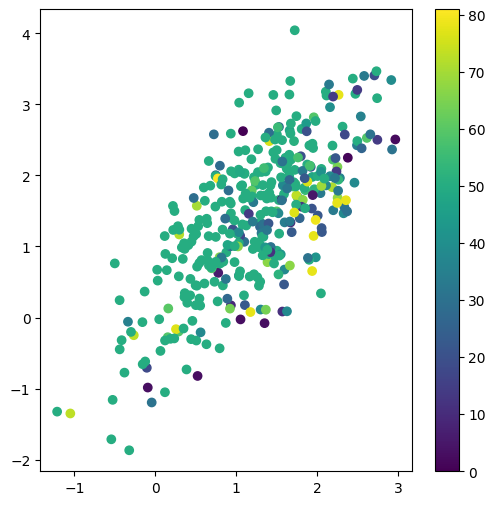

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_train)
plt.colorbar()
plt.show()

### Extreme pointes bellow

In [ ]:
np.where((encoded_imgs[:,0]>1) & (encoded_imgs[:,0]<2) & (encoded_imgs[:,1]<5) & (encoded_imgs[:,1]>3.9 ))

(array([117]),)

### middle point

In [ ]:
np.where((encoded_imgs[:,0]>0.8) & (encoded_imgs[:,0]<1) & (encoded_imgs[:,1]<1) & (encoded_imgs[:,1]>0.8 ))

(array([ 70, 316]),)

In [ ]:
np.where((encoded_imgs[:,0]>1.8) & (encoded_imgs[:,0]<2.2) & (encoded_imgs[:,1]<3) & (encoded_imgs[:,1]>2 ))

(array([  7,  11,  22,  76, 130, 158, 176, 198, 218, 242, 257, 258, 264,
        265, 280, 306, 323, 353, 372]),)

### Extreme point above

In [ ]:
np.where((encoded_imgs[:,0]>-3) & (encoded_imgs[:,0]<-1) & (encoded_imgs[:,1]<-1) & (encoded_imgs[:,1]>-7 ))

## 3D-Latent Space Analysis

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
encoded_imgs_3D = encoder.predict(x_train)

12/12 [==============================] - 0s 3ms/step


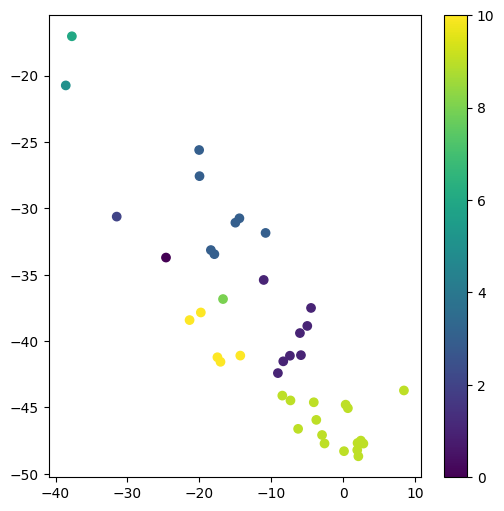

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(encoded_imgs_3D[:, 0], encoded_imgs_3D[:, 1], c=y_train)
plt.colorbar()
plt.show()

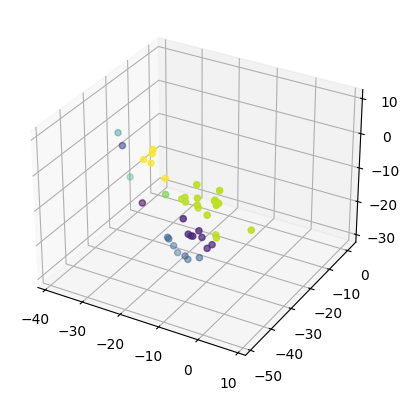

In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 5, 1)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata=encoded_imgs_3D[:, 2]
ydata=encoded_imgs_3D[:, 1]
xdata=encoded_imgs_3D[:, 0]
ax.scatter3D(xdata, ydata, zdata, c=y_train);

In [ ]:
#############################################""

In [ ]:
pip install plotly

In [ ]:
import plotly.graph_objects as go

x = xdata
y = ydata
X, Y = np.meshgrid(x, y)
Z = zdata


# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

# Update the layout for better interactivity
fig.update_layout(scene=dict(aspectmode='cube'))

# Show the plot
fig.show()

In [ ]:
# Data for three-dimensional scattered points
zdata=encoded_imgs_3D[:, 2]
ydata=encoded_imgs_3D[:, 1]
xdata=encoded_imgs_3D[:, 0]

data_plot=[xdata,ydata,zdata,y_train]
data_plot=np.transpose(data_plot)

In [ ]:
data_plot=pd.DataFrame(data_plot)
data_plot.columns = ['xdata','ydata','zdata','y_train']

In [ ]:
import plotly.express as px
df = data_plot
fig = px.scatter_3d(df, x='xdata', y='ydata', z='zdata',
              color='y_train')
fig.show()

In [ ]:
xdata=np.array(xdata)
ydata=np.array(ydata)
zdata=np.array(zdata)

In [ ]:
# cluster 1
np.where((xdata>-9.01) & (xdata<-8.30) & (ydata<-13.69) & (ydata>-14.24 ) & (zdata<-22.94) & (zdata>-23.81))

(array([ 28,  86,  91, 141]),)

In [ ]:
# cluster 2
np.where((xdata>-14.27) & (xdata<-13.63) & (ydata<-13.59) & (ydata>-14.62 ) & (zdata<-19.33) & (zdata>-19.69))

(array([ 10,  19, 138, 176, 180]),)

In [ ]:
# cluster 3
np.where((xdata>-20.86) & (xdata<-19.95) & (ydata<-6.44) & (ydata>-8.62) & (zdata<-16.77) & (zdata>-17.37))

(array([  0,   2,  27,  54,  64,  69,  81,  84, 104, 110, 124, 146, 161,
        163, 169, 205, 207]),)

In [ ]:
# cluster 4
np.where( (np.round(xdata,2)==-20.77) & (np.round(ydata,2)==-6.81) & (np.round(zdata,2)==-16.42))

(array([153]),)

## Clustering in 3D

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.cluster import KMeans
import plotly.graph_objects as go

In [ ]:
data=np.stack((xdata,ydata,zdata))

In [ ]:
data.shape

(41, 3)

In [ ]:
data=pd.DataFrame(np.transpose(data))

In [ ]:
data=np.array(data)

In [ ]:

# Define the number of clusters (k)
k = 6

# Initialize the K-means model
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the model to the data
kmeans.fit(data)

# Get cluster assignments and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=xdata,
    y=ydata,
    z=zdata,
    mode='markers',
    marker=dict(color=labels, size=5),
)])

# Add cluster centers to the plot
fig.add_trace(go.Scatter3d(
    x=centers[:, 0],
    y=centers[:, 1],
    z=centers[:, 2],
    mode='markers',
    marker=dict(color='red', size=10, symbol='cross')
))

# Show the plot
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## Exemples from Clusters

In [ ]:
# cluster 1
np.where( (np.round(xdata,2)==-2.61) & (np.round(ydata,2)==-47.72) & (np.round(zdata,2)==2.24))

(array([6]),)

In [ ]:
# cluster 2
np.where( (np.round(xdata,2)==8.43) & (np.round(ydata,2)==-43.72) & (np.round(zdata,2)==-3.14))

(array([14]),)

In [ ]:
# cluster 3
np.where( (np.round(xdata,2)==-5.01) & (np.round(ydata,2)==-38.86) & (np.round(zdata,2)==-15.56))

(array([21]),)

In [ ]:
# cluster 4
np.where( (np.round(xdata,2)==-17.50) & (np.round(ydata,2)==-41.22) & (np.round(zdata,2)==8.28))

(array([7]),)

In [ ]:
# cluster 5
np.where( (np.round(xdata,2)==-14.44) & (np.round(ydata,2)==-30.74) & (np.round(zdata,2)==-26.65))

(array([13]),)

In [ ]:
# cluster 6
np.where( (np.round(xdata,2)==-24.65) & (np.round(ydata,2)==-33.70) & (np.round(zdata,2)==-11.83))

(array([11]),)

In [ ]:
# cluster 7
np.where( (np.round(xdata,2)==-4.11) & (np.round(ydata,2)==-44.61) & (np.round(zdata,2)==-0.66))

(array([26]),)

In [ ]:
# cluster 8
np.where( (np.round(xdata,2)==-31.50) & (np.round(ydata,2)==-30.62) & (np.round(zdata,2)==0.92))

(array([36]),)

In [ ]:
# cluster 9
np.where( (np.round(xdata,2)==-38.58) & (np.round(ydata,2)==-20.73) & (np.round(zdata,2)==-2.39))

(array([9]),)

In [ ]:
# cluster 10
np.where( (np.round(xdata,2)==-37.73) & (np.round(ydata,2)==-17.02) & (np.round(zdata,2)==-17.13))

(array([1]),)